# Actividad 4 - Clasificación Multiclase: Dataset Diamonds

Aquí lo que hago es intentar predecir el tipo de **cut** (corte) de un diamante usando sus características. Como cut tiene 5 valores posibles (Fair, Good, Very Good, Premium, Ideal), es un problema de clasificación multiclase.

El proceso que sigo:
1. Cargo los datos y miro las estadísticas
2. Limpieza
3. EDA (univariante, bivariante, multivariante)
4. Preparo los datos para modelar
5. Pruebo modelos con Scikit-Learn
6. Pruebo con TensorFlow Keras

## 1. Carga de datos y estadísticas descriptivas

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargo el dataset y me quedo con 5000 filas para que vaya más rápido
df = sns.load_dataset('diamonds').sample(5000, random_state=42).reset_index(drop=True)
print(f'El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas')
df.head(10)

El dataset tiene 5000 filas y 10 columnas


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.24,Ideal,G,VVS1,62.1,56.0,559,3.97,4.00,2.47
1,0.58,Very Good,F,VVS2,60.0,57.0,2201,5.44,5.42,3.26
2,0.40,Ideal,E,VVS2,62.1,55.0,1238,4.76,4.74,2.95
3,0.43,Premium,E,VVS2,60.8,57.0,1304,4.92,4.89,2.98
4,1.55,Ideal,E,SI2,62.3,55.0,6901,7.44,7.37,4.61
5,1.00,Fair,E,SI2,55.4,62.0,3011,6.63,6.59,3.66
6,0.51,Ideal,F,VS1,60.2,56.0,1765,5.22,5.24,3.15
7,0.52,Ideal,D,VS2,62.0,56.0,1679,5.17,5.19,3.21
8,0.62,Premium,E,VS2,60.0,59.0,2102,5.58,5.56,3.34
9,1.14,Ideal,H,SI1,60.3,57.0,4789,6.79,6.85,4.11


Qué columnas hay y de qué tipo son, para saber cuáles son numéricas y cuáles categóricas.

In [137]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    5000 non-null   float64 
 1   cut      5000 non-null   category
 2   color    5000 non-null   category
 3   clarity  5000 non-null   category
 4   depth    5000 non-null   float64 
 5   table    5000 non-null   float64 
 6   price    5000 non-null   int64   
 7   x        5000 non-null   float64 
 8   y        5000 non-null   float64 
 9   z        5000 non-null   float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 289.1 KB


Hay 3 categóricas (cut, color, clarity) y 7 numéricas. La que quiero predecir es **cut**.

In [138]:
# Estadísticas descriptivas de las numéricas
df.describe()

,carat,depth,table,price,x,y,z
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.797118,61.783100,57.438580,3917.294400,5.721784,5.722654,3.533868
std,0.483612,1.436638,2.267361,4044.422491,1.138951,1.131908,0.702334
min,0.200000,54.400000,49.000000,335.000000,3.850000,3.810000,1.410000
25%,0.390000,61.100000,56.000000,920.500000,4.680000,4.690000,2.890000
50%,0.700000,61.900000,57.000000,2352.000000,5.690000,5.700000,3.510000
75%,1.040000,62.500000,59.000000,5252.750000,6.540000,6.540000,4.030000
max,4.010000,71.200000,73.000000,18823.000000,10.140000,10.100000,6.310000


En el dataset completo de diamonds hay filas con x, y, z = 0 (un diamante no puede medir 0), pero en nuestra muestra de 5000 no aparece ningún caso así. Aun así, compruebo por si acaso.

In [139]:
# Estadísticas de las categóricas
df.describe(include='category')

,cut,color,clarity
count,5000,5000,5000
unique,5,7,8
top,Ideal,G,SI1
freq,1953,1044,1182


In [140]:
# Valores únicos de la variable target
print('Valores de cut:', df['cut'].unique())
print()
print(df['cut'].value_counts())

Valores de cut: ['Ideal', 'Very Good', 'Premium', 'Fair', 'Good']
Categories (5, str): ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']

cut
Ideal        1953
Premium      1312
Very Good    1108
Good          465
Fair          162
Name: count, dtype: int64


5 categorías. Ideal es la que más tiene con diferencia (1953) y Fair la que menos (162). Hay desbalanceo pero tampoco es brutal.

## 2. Limpieza de datos

In [141]:
# Compruebo si hay nulos
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

No hay nulos ni valores 0 en las dimensiones. La muestra de 5000 está limpia en ese sentido.

In [142]:
# Cuántas filas tienen dimensión 0
print('Filas con x=0:', (df['x'] == 0).sum())
print('Filas con y=0:', (df['y'] == 0).sum())
print('Filas con z=0:', (df['z'] == 0).sum())
print()
df[(df['x'] == 0) | (df['y'] == 0) | (df['z'] == 0)]

Filas con x=0: 0
Filas con y=0: 0
Filas con z=0: 0



,carat,cut,color,clarity,depth,table,price,x,y,z


En la muestra de 5000 no hay filas con dimensión 0, así que no hace falta imputar nada. Aun así, dejo el reemplazo por si acaso y el KNNImputer en el pipeline como precaución.

In [143]:
# Reemplazo 0 por NaN en x, y, z
df['x'] = df['x'].replace(0, np.nan)
df['y'] = df['y'].replace(0, np.nan)
df['z'] = df['z'].replace(0, np.nan)

print('Nulos tras reemplazar ceros:')
print(df.isna().sum())

Nulos tras reemplazar ceros:
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


In [144]:
# Duplicados
print(f'Filas duplicadas: {df.duplicated().sum()}')

Filas duplicadas: 2


2 duplicados. Pero tiene sentido que haya diamantes con las mismas medidas, así que los dejo.

## 3. EDA - Análisis Exploratorio de Datos

### 3.1 EDA Univariante

Miro cada variable por separado.

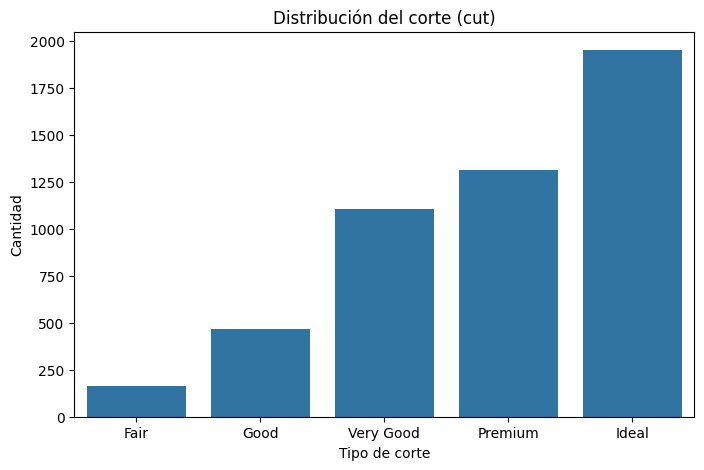

In [145]:
# Distribución de cut
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='cut', order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'])
plt.title('Distribución del corte (cut)')
plt.xlabel('Tipo de corte')
plt.ylabel('Cantidad')
plt.show()

Ideal domina bastante, seguida de Premium y Very Good. Fair es la minoría. No es un desbalanceo extremo como para tener que usar SMOTE sí o sí.

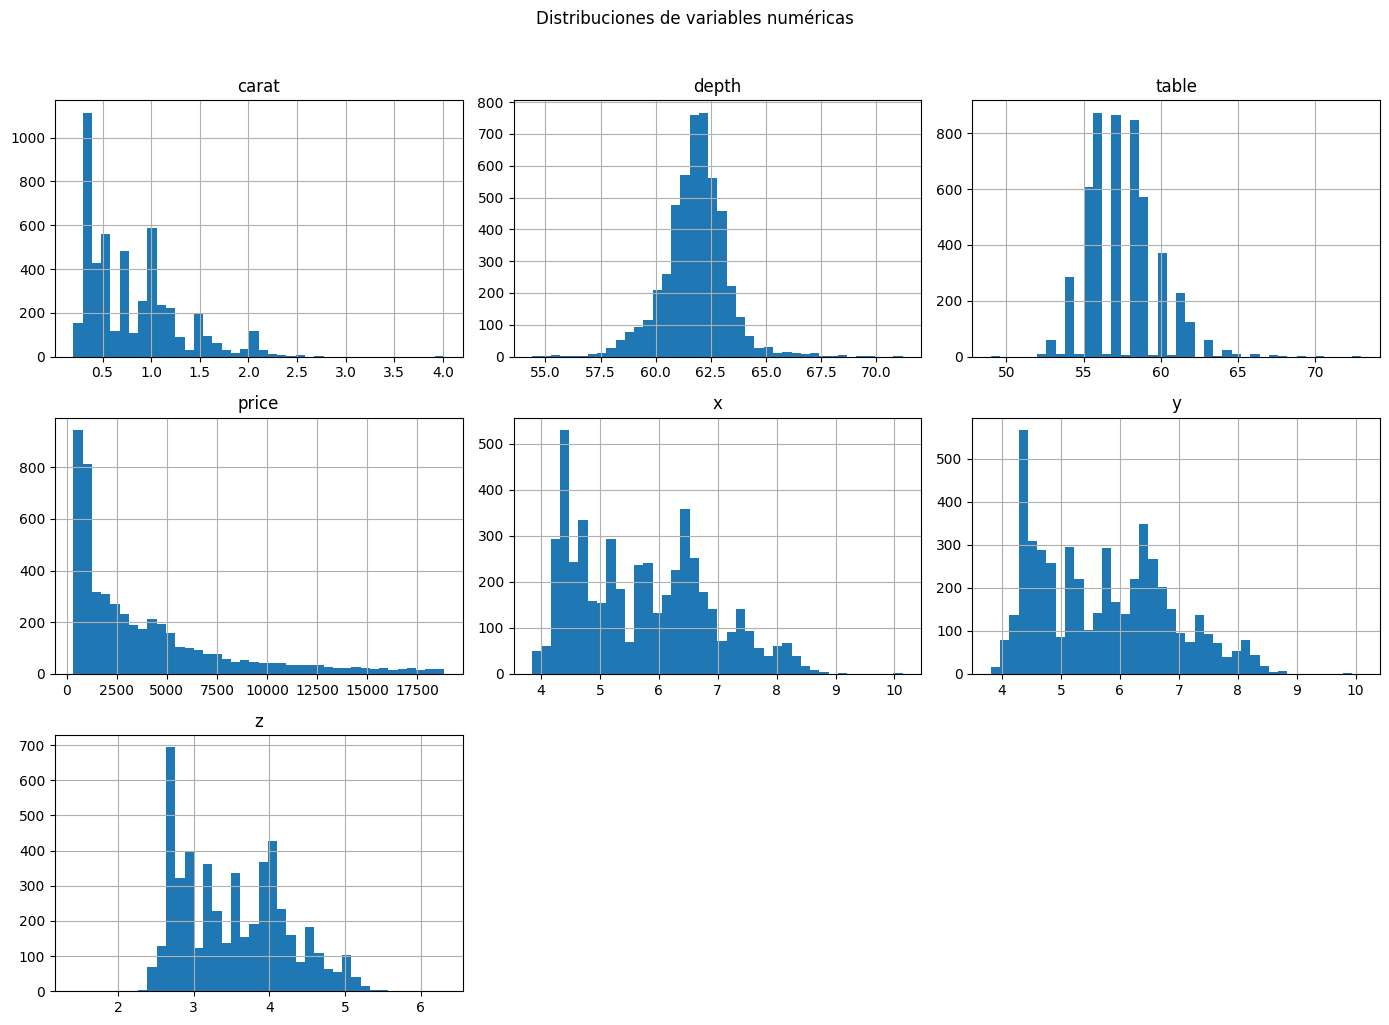

In [146]:
# Histogramas de las numéricas
df.hist(figsize=(14, 10), bins=40)
plt.suptitle('Distribuciones de variables numéricas', y=1.02)
plt.tight_layout()
plt.show()

Carat y price tienen sesgo a la derecha (muchos valores bajos, pocos altos). Depth y table más centradas. x, y, z se parecen a carat.

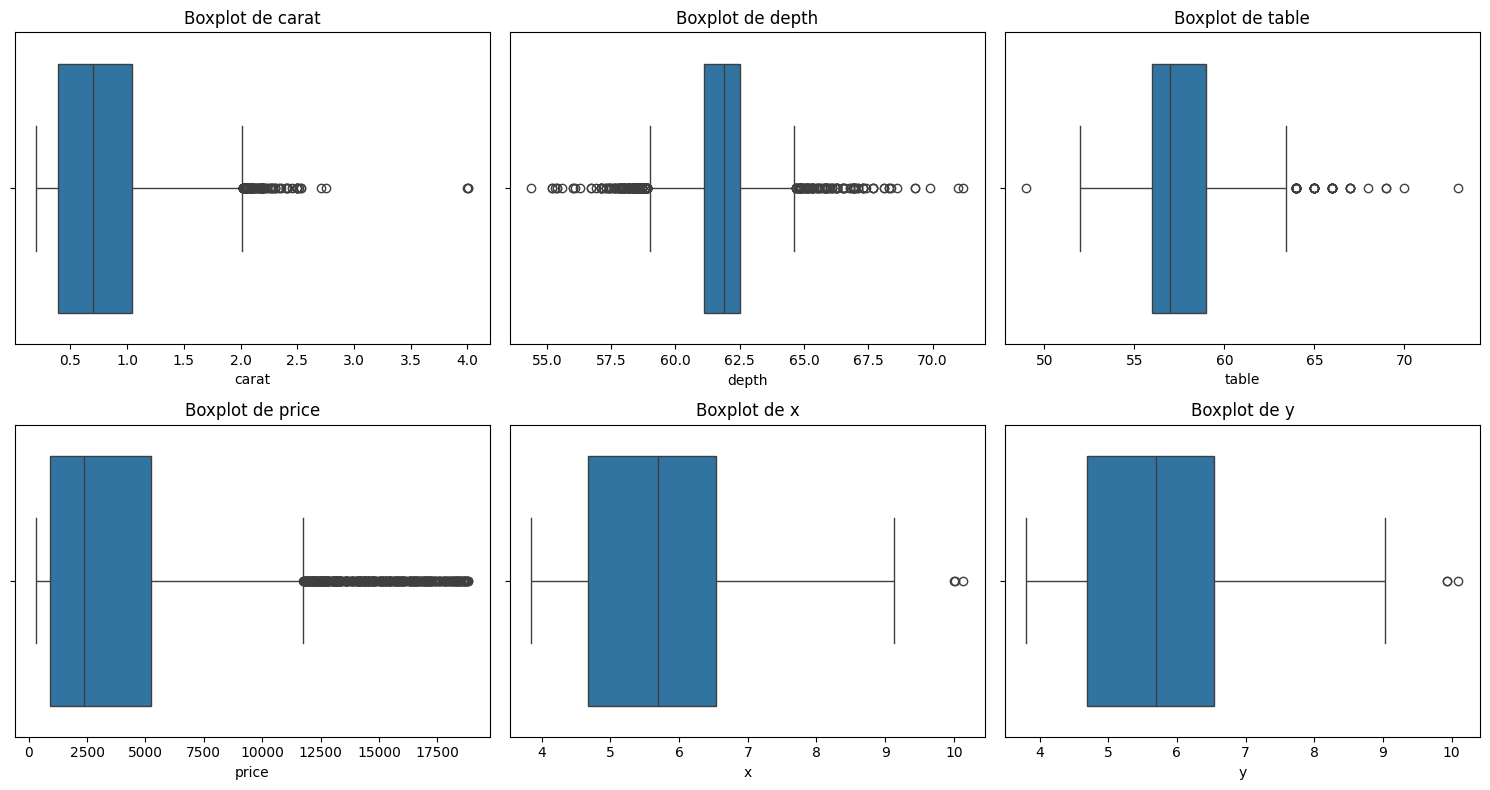

In [147]:
# Boxplots para ver outliers
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
columnas_num = ['carat', 'depth', 'table', 'price', 'x', 'y']
for i, col in enumerate(columnas_num):
    ax = axes[i // 3, i % 3]
    sns.boxplot(data=df, x=col, ax=ax)
    ax.set_title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

Outliers en casi todas, sobre todo en price y carat. No los quito porque son diamantes reales.

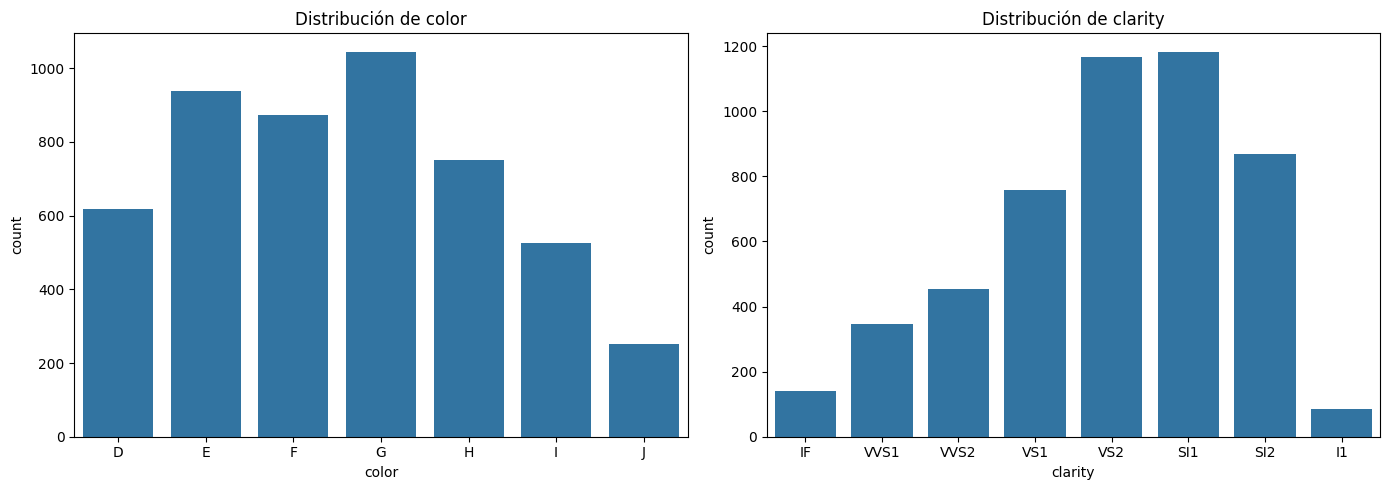

In [148]:
# Distribución de color y clarity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(data=df, x='color', ax=axes[0])
axes[0].set_title('Distribución de color')
sns.countplot(data=df, x='clarity', ax=axes[1])
axes[1].set_title('Distribución de clarity')
plt.tight_layout()
plt.show()

### 3.2 EDA Bivariante

Miro relaciones entre pares de variables.

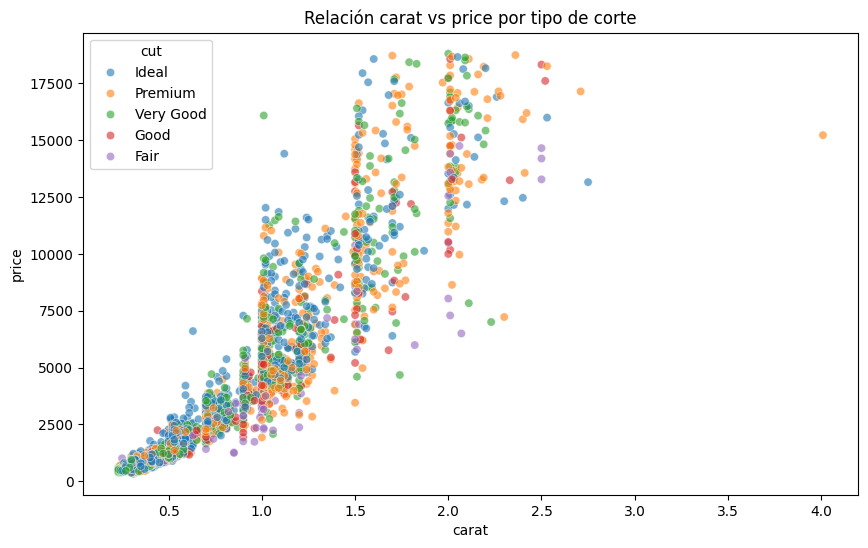

In [149]:
# Carat vs price por tipo de corte
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.sample(3000, random_state=42), x='carat', y='price', hue='cut', alpha=0.6)
plt.title('Relación carat vs price por tipo de corte')
plt.show()

A más carat, más precio, lógico. Pero los tipos de corte se mezclan mucho entre sí, así que separar las clases no va a ser fácil.

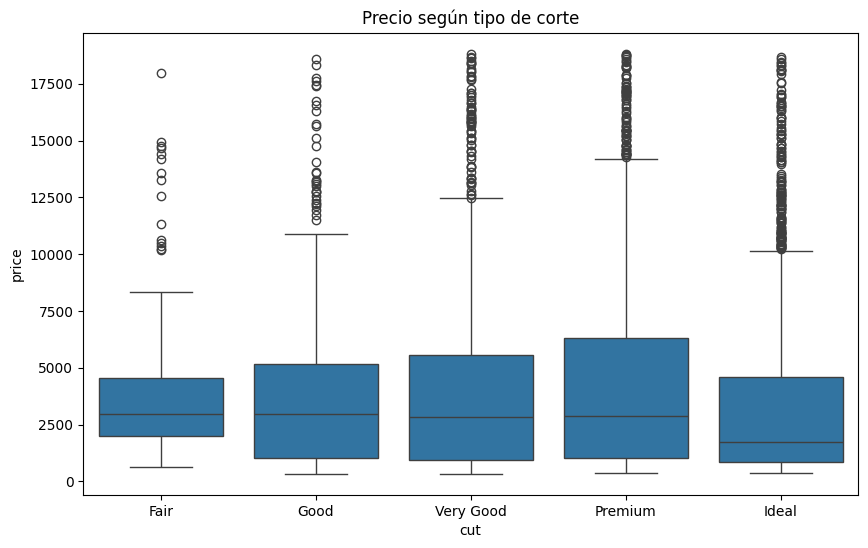

In [150]:
# Precio según corte
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cut', y='price', order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'])
plt.title('Precio según tipo de corte')
plt.show()

Fair tiene la mediana de precio más alta que Ideal, aunque sea el peor corte. Esto es porque los Fair suelen ser diamantes más grandes (más carats), y el tamaño sube el precio aunque el corte sea malo.

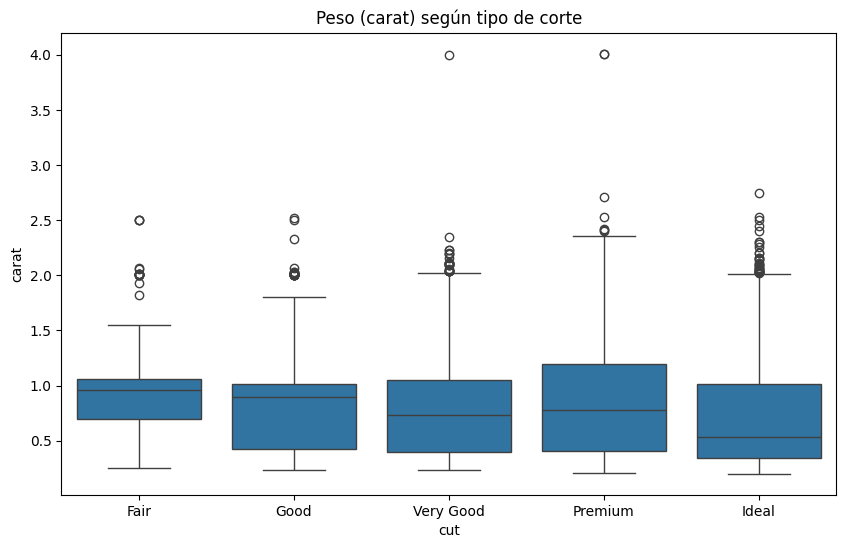

In [151]:
# Carat según corte
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cut', y='carat', order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'])
plt.title('Peso (carat) según tipo de corte')
plt.show()

Se confirma, los Fair pesan más. Ideal tiene la mediana de carat más baja.

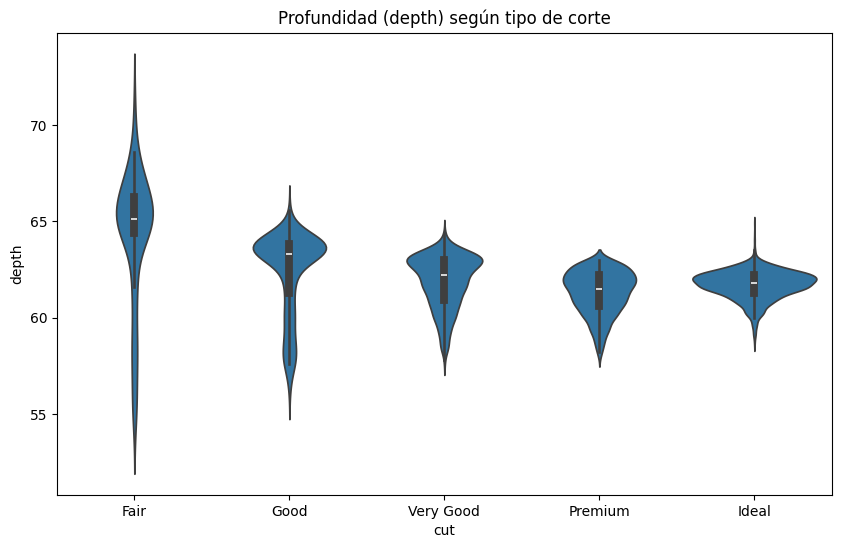

In [152]:
# Depth por corte
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='cut', y='depth', order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'])
plt.title('Profundidad (depth) según tipo de corte')
plt.show()

Depth tiene distribuciones bastante distintas según el corte. Puede ser una variable importante para clasificar.

### 3.3 EDA Multivariante

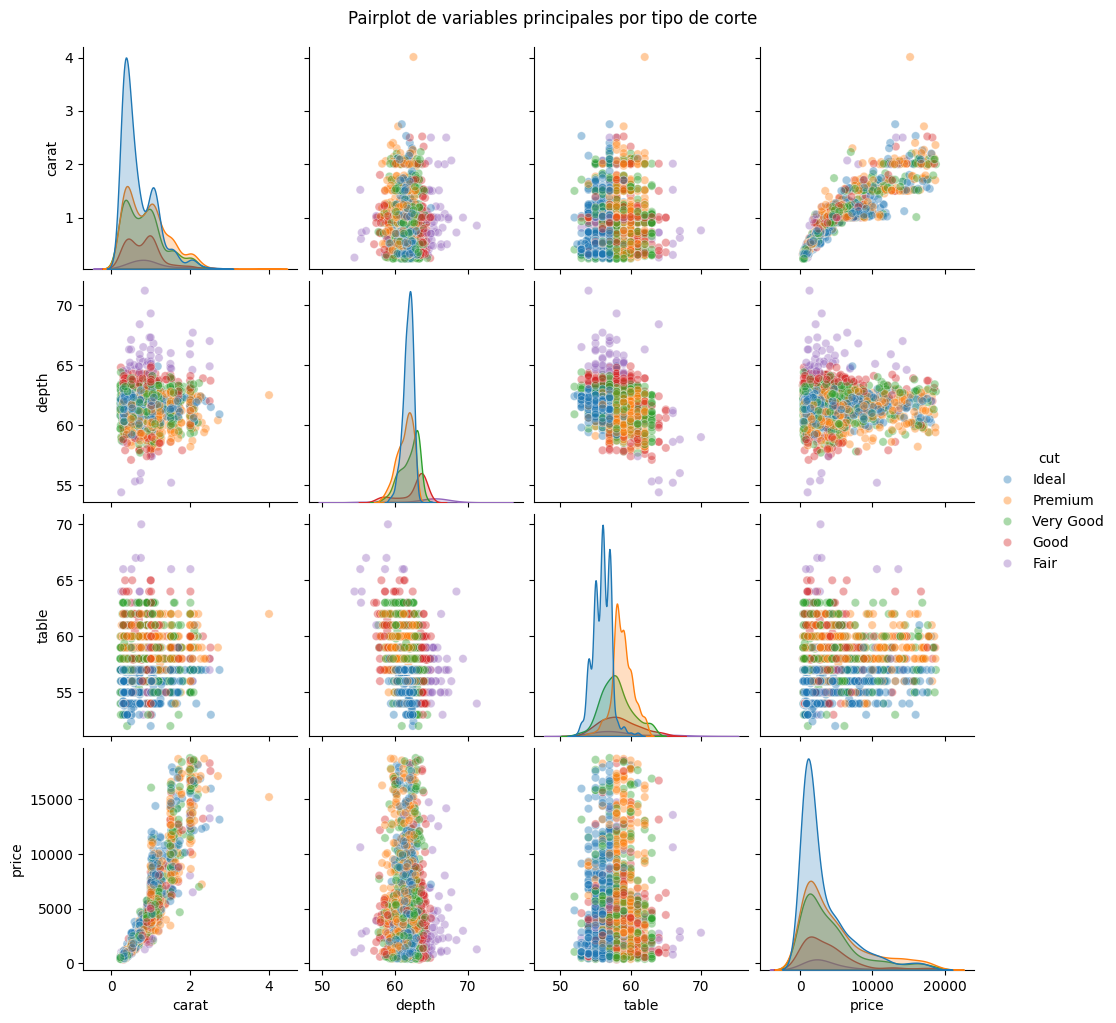

In [153]:
# Pairplot con una muestra para no saturar
muestra = df[['carat', 'depth', 'table', 'price', 'cut']].sample(2000, random_state=42)
sns.pairplot(muestra, hue='cut', plot_kws={'alpha': 0.4})
plt.suptitle('Pairplot de variables principales por tipo de corte', y=1.02)
plt.show()

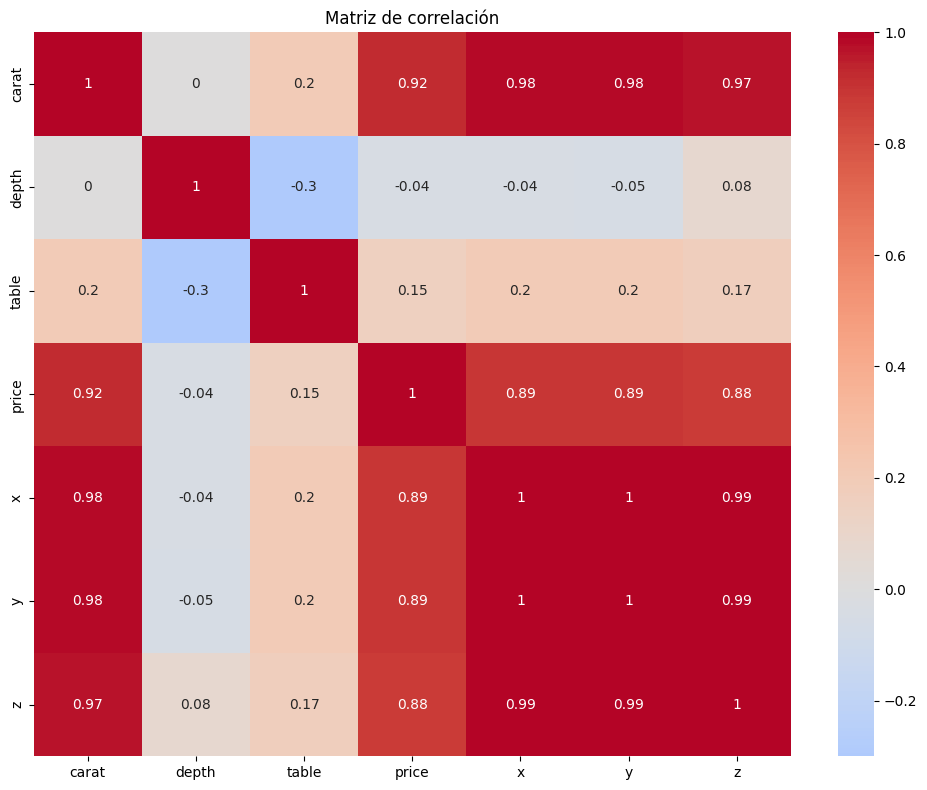

In [154]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
corr = df.select_dtypes(include=[np.number]).corr().round(2)
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de correlación')
plt.tight_layout()
plt.show()

Correlación muy alta entre carat, x, y, z y price. Normal: un diamante más grande pesa más y cuesta más. Depth y table van más por libre.

## 4. Preparación de datos para el modelado

Separo features (X) y target (y), hago train-test split y monto los pipelines de preprocesado.

Color y clarity se codifican dentro del pipeline. Cut también hay que pasarla a numérica.

In [155]:
from sklearn.model_selection import train_test_split

X = df.drop('cut', axis=1)
y = df['cut']

print('Columnas en X:', list(X.columns))
print('Target y:', y.unique())

Columnas en X: ['carat', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']
Target y: ['Ideal', 'Very Good', 'Premium', 'Fair', 'Good']
Categories (5, str): ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']


In [156]:
# Paso cut a numérica con orden
cut_map = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
y = y.map(cut_map)

print('Distribución de y:')
print(y.value_counts().sort_index())

Distribución de y:
cut
4    1953
3    1312
2    1108
1     465
0     162
Name: count, dtype: int64


In [157]:
# Train-test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Train: {X_train.shape[0]} filas')
print(f'Test: {X_test.shape[0]} filas')
print()
print('Proporción de clases en train:')
print(y_train.value_counts(normalize=True).sort_index().round(3))

Train: 4000 filas
Test: 1000 filas

Proporción de clases en train:
cut
4    0.390
3    0.262
2    0.222
1    0.093
0    0.032
Name: proportion, dtype: float64


In [158]:
# Separo columnas por tipo
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print('Numéricas:', numerical_cols)
print('Categóricas:', categorical_cols)

Numéricas: ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
Categóricas: ['color', 'clarity']


In [159]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder

# Numéricas: relleno nulos con KNNImputer y escalo
pipeline_num = make_pipeline(
    KNNImputer(n_neighbors=5),
    MinMaxScaler()
)

# Color y clarity tienen orden, uso OrdinalEncoder
color_order = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

pipeline_cat = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(categories=[color_order, clarity_order])
)

# Junto todo
preprocessor = ColumnTransformer([
    ('num', pipeline_num, numerical_cols),
    ('cat', pipeline_cat, categorical_cols)
])

print('Preprocesador listo')

Preprocesador listo


## 5. Modelado con Scikit-Learn

Pruebo varios algoritmos y comparo. Cada uno va dentro de un pipeline con el preprocesado.

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

In [161]:
# Tabla para ir guardando los resultados
resultados = pd.DataFrame(columns=['Modelo', 'Accuracy CV', 'Accuracy Test', 'Precision', 'Recall', 'F1'])

def evaluar_modelo(nombre, modelo):
    pipe = make_pipeline(preprocessor, modelo)
    
    # Cross-validation sobre train
    scores_cv = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
    
    # Entreno con todo el train y evalúo en test
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    acc_test = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    resultados.loc[len(resultados)] = [nombre, round(scores_cv.mean(), 4), round(acc_test, 4), round(prec, 4), round(rec, 4), round(f1, 4)]
    
    print(f'--- {nombre} ---')
    print(f'  Accuracy CV (media): {scores_cv.mean():.4f} (+/- {scores_cv.std():.4f})')
    print(f'  Accuracy Test: {acc_test:.4f}')
    print(f'  F1 Test (weighted): {f1:.4f}')
    print()
    
    return pipe

### 5.1 Regresión Logística

In [162]:
pipe_lr = evaluar_modelo('Logistic Regression', LogisticRegression(max_iter=5000))

--- Logistic Regression ---
  Accuracy CV (media): 0.6068 (+/- 0.0204)
  Accuracy Test: 0.6140
  F1 Test (weighted): 0.5590



### 5.2 K-Nearest Neighbors

In [163]:
pipe_knn = evaluar_modelo('KNN (k=5)', KNeighborsClassifier(n_neighbors=5))

--- KNN (k=5) ---
  Accuracy CV (media): 0.5368 (+/- 0.0185)
  Accuracy Test: 0.5530
  F1 Test (weighted): 0.5426



### 5.3 Decision Tree

In [164]:
pipe_dt = evaluar_modelo('Decision Tree', DecisionTreeClassifier(random_state=42))

--- Decision Tree ---
  Accuracy CV (media): 0.6395 (+/- 0.0221)
  Accuracy Test: 0.6600
  F1 Test (weighted): 0.6606



### 5.4 Random Forest

In [165]:
pipe_rf = evaluar_modelo('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42))

--- Random Forest ---
  Accuracy CV (media): 0.7280 (+/- 0.0164)
  Accuracy Test: 0.7450
  F1 Test (weighted): 0.7346



### 5.5 SVC

In [166]:
pipe_svc = evaluar_modelo('SVC', SVC(random_state=42));

--- SVC ---
  Accuracy CV (media): 0.5085 (+/- 0.0092)
  Accuracy Test: 0.5120
  F1 Test (weighted): 0.3988



### 5.6 Comparación de modelos

In [167]:
resultados.sort_values('F1', ascending=False)

,Modelo,Accuracy CV,Accuracy Test,Precision,Recall,F1
3,Random Forest,0.7280,0.745,0.7362,0.745,0.7346
2,Decision Tree,0.6395,0.660,0.6613,0.660,0.6606
0,Logistic Regression,0.6068,0.614,0.5844,0.614,0.5590
1,KNN (k=5),0.5368,0.553,0.5478,0.553,0.5426
4,SVC,0.5085,0.512,0.3308,0.512,0.3988


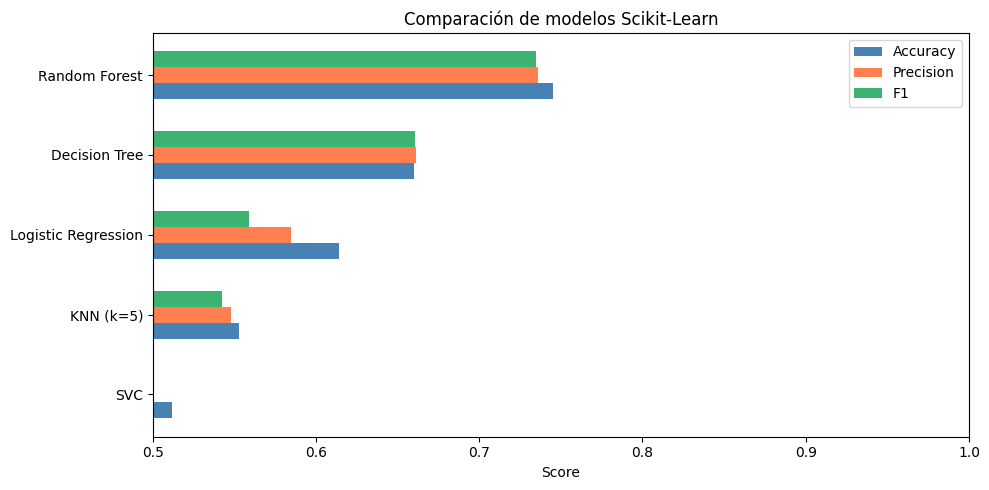

In [168]:
# Gráfico comparativo
fig, ax = plt.subplots(figsize=(10, 5))
resultados_sorted = resultados.sort_values('F1', ascending=True)

x = np.arange(len(resultados_sorted))
width = 0.2

ax.barh(x - width, resultados_sorted['Accuracy Test'], width, label='Accuracy', color='steelblue')
ax.barh(x, resultados_sorted['Precision'], width, label='Precision', color='coral')
ax.barh(x + width, resultados_sorted['F1'], width, label='F1', color='mediumseagreen')

ax.set_yticks(x)
ax.set_yticklabels(resultados_sorted['Modelo'])
ax.set_xlabel('Score')
ax.set_title('Comparación de modelos Scikit-Learn')
ax.legend()
ax.set_xlim(0.5, 1.0)
plt.tight_layout()
plt.show()

### 5.7 Classification Report y Matriz de Confusión del mejor modelo

In [169]:
# Report del Random Forest
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

nombres_clases = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
print(classification_report(y_test, y_pred_rf, target_names=nombres_clases))

              precision    recall  f1-score   support

        Fair       0.90      0.84      0.87        32
        Good       0.74      0.69      0.72        93
   Very Good       0.61      0.42      0.50       222
     Premium       0.68      0.80      0.74       262
       Ideal       0.83      0.90      0.86       391

    accuracy                           0.74      1000
   macro avg       0.75      0.73      0.74      1000
weighted avg       0.74      0.74      0.73      1000



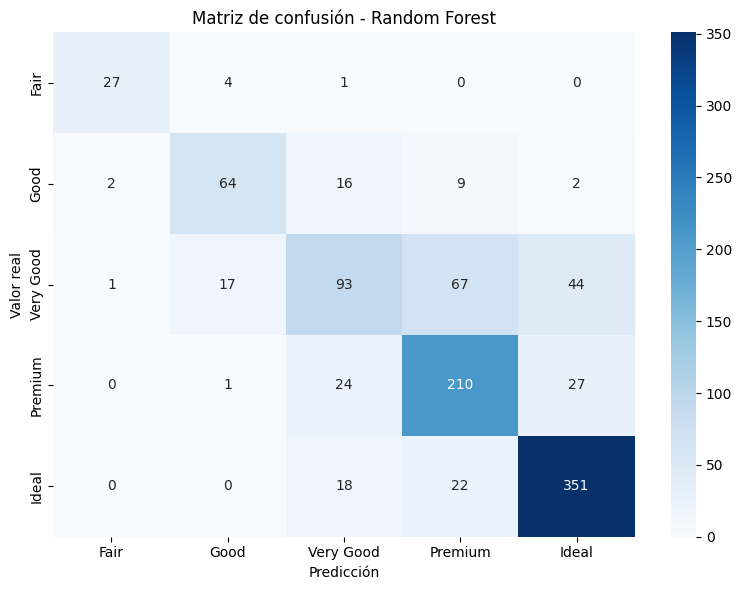

In [170]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nombres_clases,
            yticklabels=nombres_clases)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión - Random Forest')
plt.tight_layout()
plt.show()

Donde más falla es confundiendo Premium con Very Good, y a veces Ideal con Premium.

## 6. Modelado con TensorFlow Keras

Pruebo con una red neuronal para comparar con sklearn. Uso el mismo preprocesado.

In [171]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [172]:
# Preproceso con el mismo preprocessor de sklearn
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print(f'Shape X_train preprocesado: {X_train_prep.shape}')
print(f'Shape X_test preprocesado: {X_test_prep.shape}')

Shape X_train preprocesado: (4000, 9)
Shape X_test preprocesado: (1000, 9)


Para multiclase en Keras hay que pasar el target a one-hot. En vez de un número 0-4, se convierte en un vector de 5 posiciones.

In [173]:
# One-hot encoding del target
num_clases = 5
y_train_onehot = keras.utils.to_categorical(y_train, num_clases)
y_test_onehot = keras.utils.to_categorical(y_test, num_clases)

print('Ejemplo de y_train original:', y_train.values[:5])
print('Ejemplo de y_train one-hot:')
print(y_train_onehot[:5])

Ejemplo de y_train original: [3, 0, 2, 4, 4]
Categories (5, int64): [4, 3, 2, 1, 0]
Ejemplo de y_train one-hot:
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [174]:
# Red neuronal: 5 neuronas de salida con softmax
n_features = X_train_prep.shape[1]

modelo_nn = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_clases, activation='softmax')
])

modelo_nn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,885 (11.27 KB)

 Trainable params: 2,885 (11.27 KB)

 Non-trainable params: 0 (0.00 B)

In [175]:
# categorical_crossentropy porque es multiclase con one-hot
modelo_nn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [176]:
# Entreno. validation_split=0.2 separa parte del train para ver si generaliza
historia = modelo_nn.fit(
    X_train_prep, y_train_onehot,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3728 - loss: 1.4246 - val_accuracy: 0.4013 - val_loss: 1.3579
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.4356 - loss: 1.3466 - val_accuracy: 0.4187 - val_loss: 1.3460
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.4434 - loss: 1.3315 - val_accuracy: 0.4212 - val_loss: 1.3367
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.4497 - loss: 1.3169 - val_accuracy: 0.4338 - val_loss: 1.3250
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.4647 - loss: 1.3012 - val_accuracy: 0.4500 - val_loss: 1.3127
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.4841 - loss: 1.2782 - val_accuracy: 0.4625 - val_loss: 1.2797
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5041 - loss: 1.2536 - val_accuracy: 0.4900 - val_loss: 1.2820
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.5241 - loss: 1.2347 - val_accuracy: 0.48

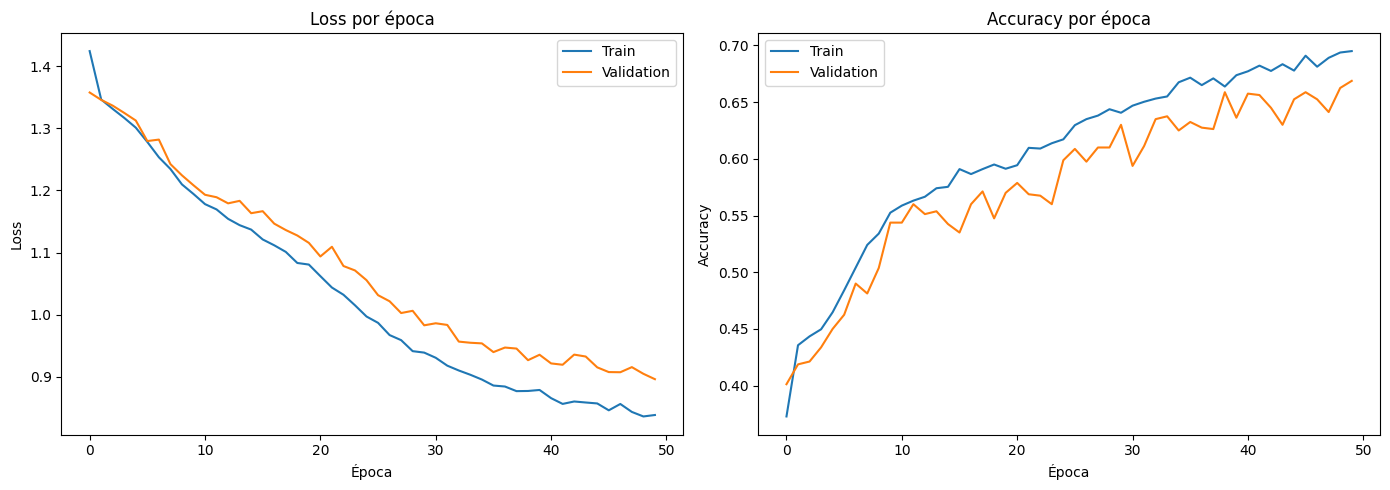

In [177]:
# Curvas de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(historia.history['loss'], label='Train')
axes[0].plot(historia.history['val_loss'], label='Validation')
axes[0].set_title('Loss por época')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(historia.history['accuracy'], label='Train')
axes[1].plot(historia.history['val_accuracy'], label='Validation')
axes[1].set_title('Accuracy por época')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

Si la curva de validation se separa mucho de train, hay overfitting. Si van más o menos juntas, bien.

In [178]:
# Evalúo en test
loss_test, acc_test = modelo_nn.evaluate(X_test_prep, y_test_onehot, verbose=0)
print(f'Loss en test: {loss_test:.4f}')
print(f'Accuracy en test: {acc_test:.4f}')

Loss en test: 0.8330
Accuracy en test: 0.6830


In [179]:
# Predicciones: me quedo con la clase con mayor probabilidad
y_pred_proba_nn = modelo_nn.predict(X_test_prep)
y_pred_nn = np.argmax(y_pred_proba_nn, axis=1)

print(classification_report(y_test, y_pred_nn, target_names=nombres_clases))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
              precision    recall  f1-score   support

        Fair       0.79      0.69      0.73        32
        Good       0.53      0.35      0.43        93
   Very Good       0.47      0.25      0.33       222
     Premium       0.62      0.81      0.71       262
       Ideal       0.80      0.92      0.86       391

    accuracy                           0.68      1000
   macro avg       0.64      0.61      0.61      1000
weighted avg       0.65      0.68      0.66      1000



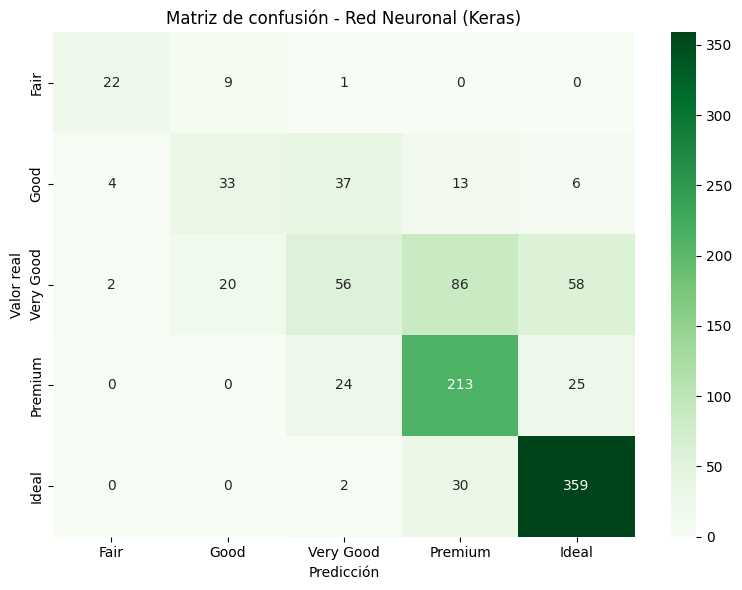

In [180]:
# Matriz de confusión de la red neuronal
cm_nn = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens',
            xticklabels=nombres_clases,
            yticklabels=nombres_clases)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión - Red Neuronal (Keras)')
plt.tight_layout()
plt.show()

## 7. Conclusiones

Lo que he sacado en claro:
- Premium y Very Good se confunden mucho entre sí, sus características se solapan bastante y a los modelos les cuesta separarlos.
- Random Forest ha ido bien, como suele pasar con datos tabulares.
- La red neuronal da resultados parecidos a sklearn, para este tipo de datos no aporta mucha ventaja.
- Los pipelines con ColumnTransformer simplifican bastante el preprocesado y evitan data leakage.

La idea era más practicar el flujo completo (carga, EDA, limpieza, modelado, evaluación) que sacar el accuracy más alto.